In [1]:
import operator
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn import feature_selection
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler, RobustScaler, Imputer, LabelEncoder
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

from IPython.core.pylabtools import figsize 
%matplotlib inline

In [2]:
class ItemSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        return data_dict[self.key]

In [3]:
RANDOM_STATE = 42

In [32]:
integral = pd.read_csv("../data/processed/integral/dataset.csv.gz", index_col="MUTANT").drop("TYPE", 1)

# genomic = pd.read_csv("../data/processed/genomic/dataset.csv.gz", index_col='MUTANT').drop("TYPE", 1)
varq = pd.read_csv("../data/processed/varq/dataset.csv.gz", index_col="MUTANT")

full = varq.merge(integral, right_index=True, left_index=True, how="left")

In [33]:
full.to_csv("../data/processed/varq_integral/dataset.csv.gz", index=True, index_label="MUTANT", compression="gzip")

In [4]:
full = pd.read_csv("../data/processed/varq_integral/dataset.csv.gz", index_col="MUTANT")

In [5]:
full.shape

(7418, 73)

In [6]:
full.TYPE.value_counts(normalize=True)

Pathogenic    0.724858
Benign        0.275142
Name: TYPE, dtype: float64

In [7]:
full.describe()

,SASA,SASA_PERCENTAGE,BFACTOR,SWITCHBILITY,AGGREGABILITY,CONSERVATION,VARIATION_ENERGY,CONS,SNP_DEN,HAPMAP_SNP_DEN,...,AROMATICITY_DIFF,AROMATICITY_LOG_RATIO,ISOELECTRIC_POINT_DIFF,ISOELECTRIC_POINT_LOG_RATIO,GRAVY_DIFF,GRAVY_LOG_RATIO,INSTABILITY_INDEX_DIFF,INSTABILITY_INDEX_LOG_RATIO,FLEXIBILITY_DIFF,FLEXIBILITY_LOG_RATIO
count,7070.000000,7070.000000,7070.000000,6704.000000,5335.000000,2742.000000,7418.000000,4744.000000,4744.000000,4744.000000,...,6644.000000,5118.000000,6644.000000,6644.000000,6644.000000,5.435000e+03,6644.000000,5846.000000,6613.000000,6613.000000
mean,32.105675,0.150610,56.445569,0.384835,5.017957,0.330460,2.914977,0.686224,0.076982,0.000110,...,0.019433,1.985775,0.735431,2.005113,0.234660,2.364199e+12,13.451748,2.040824,0.009634,2.000381
std,39.148405,0.176877,71.760154,0.890387,17.607171,0.188785,4.842729,0.089664,0.087754,0.000839,...,0.026050,0.326575,0.981368,0.077378,0.173779,1.094083e+14,12.849963,1.012928,0.006929,0.008591
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.130000,-12.642100,0.388350,0.000000,0.000000,...,0.000000,1.000000,0.000000,1.706712,0.000000,-1.416794e+02,0.001250,-35.097991,0.000003,1.972809
25%,0.670000,0.000000,19.765000,0.000000,0.000000,0.250000,0.257785,0.623586,0.032110,0.000000,...,0.004167,1.939356,0.000000,1.986984,0.093333,1.368368e+00,3.778750,1.958330,0.004088,1.994288
50%,15.208000,0.070000,37.342500,0.009150,0.000000,0.300000,1.512550,0.700991,0.049020,0.000000,...,0.008333,1.941036,0.237854,2.000000,0.202500,1.908269e+00,9.599583,2.006283,0.008247,2.000324
75%,52.149250,0.270000,61.138125,0.277000,0.163000,0.370000,3.885900,0.757558,0.075804,0.000000,...,0.020833,1.942567,1.341888,2.023071,0.341250,2.423760e+00,19.269896,2.092317,0.013802,2.006216
max,246.410000,0.750000,755.610000,8.720000,100.000000,4.770000,57.513400,0.892079,0.536765,0.014085,...,0.222222,3.662755,6.305908,2.445119,1.272222,7.318295e+15,105.402778,20.143583,0.038935,2.025499


In [8]:
le = LabelEncoder()
X = full[~full.TYPE.isnull()].drop(['TYPE'], 1)
y = le.fit_transform(full[~full.TYPE.isnull()].TYPE)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

cat_vars_genomic = ['INTRON','MISSENSE', 'NEAR-GENE', 'NCRNA', 'CODING-SYNON', 'UNTRANSLATED',
       'NONSENSE', 'SPLICE', 'STOP-LOSS']

cat_vars_structural = ['BINDING','ACT_SITE','SITE','LIPID','METAL','CARBOHYD',
                       'DNA_BIND','NP_BIND','CA_BIND','DISULFID','SE_CYS','MOD_RES','PROPEP','SIGNALP',
                       'TRANSMEM','COMPBIAS','REP','MOTIF','ZN_FING','REGIONS','PPI','RNABD','TF','LOC',
                       'MMBRBD','CHROM','POSTMODREC','POSTMODENZ']

cat_vars_varq = ["PDB", "3DID"]

cat_vars  = cat_vars_genomic + cat_vars_structural + cat_vars_varq
cont_vars = X.columns.drop(cat_vars, 1).tolist()



In [9]:
impute = ('union', 
          FeatureUnion(
              transformer_list=[
                  ('continuous', Pipeline([
                      ('selector', ItemSelector(key=cont_vars)),
                      ('imputer', Imputer(missing_values="NaN", strategy="median"))
                  ])),
                  ('categorical', Pipeline([
                      ('selector', ItemSelector(key=cat_vars)),
                      ('imputer', Imputer(missing_values="NaN", strategy="most_frequent"))
                      
                  ]))
              ]))
                  

# impute = ('imputer', Imputer(missing_values="NaN", strategy="median"))
scale = ('scaler', RobustScaler())

model_dict = {
    'lr':{'pipe':[impute, scale, ('lr', LogisticRegression())],
        'params':[{'lr__C' : [.001, .01, .1, 1, 10, 100, 1000], 'lr__class_weight':[None, 'balanced']}],
        'name':'LogisticRegression'
    },
    'rf':{'pipe':[impute, ('rf', RandomForestClassifier(random_state=RANDOM_STATE))],
        'params':[{'rf__max_depth':[3,5,7], 'rf__n_estimators':[10,50,100], 'rf__max_features':[4,'sqrt',0.2]}],
        'name':'Random Forest'
    },
    'svc':{'pipe': [impute, scale, ('svc', SVC(kernel='rbf'))],
           'params':[{'svc__kernel': ['rbf'], 'svc__gamma': [1e-2, 1e-3, 1e-4, 1e-5],
                'svc__C': [0.001, 0.10, 0.1, 10, 25, 50, 100, 1000]}]
        
    },
}

In [10]:
folds = 3
skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=1001)
algorithm = 'rf'
model = Pipeline(model_dict[algorithm]['pipe'])
param_list = [model_dict[algorithm]['params']][0]
gs = GridSearchCV(model, param_list, cv=skf.split(X_train, y_train), n_jobs=3, 
                  scoring='roc_auc', verbose=1, refit=True)


In [11]:
X.shape

(7418, 72)

In [12]:
print (X_train.shape[0])
print (X_train.shape[0] / X.shape[0])

4970
0.66999191156646


In [13]:
gs.fit(X_train, y_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=3)]: Done  76 out of  81 | elapsed:    9.6s remaining:    0.6s
[Parallel(n_jobs=3)]: Done  81 out of  81 | elapsed:   11.1s finished


GridSearchCV(cv=<generator object _BaseKFold.split at 0x7f4085d21db0>,
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('union', FeatureUnion(n_jobs=1,
       transformer_list=[('continuous', Pipeline(memory=None,
     steps=[('selector', ItemSelector(key=['SASA', 'SASA_PERCENTAGE', 'BFACTOR', 'SWITCHBILITY', 'AGGREGABILITY', 'CONSERVATION', 'VARIATION_ENERGY', 'CONS', 'SNP_DEN', 'HAPMAP_SNP_DEN', 'PHYLOP46WA...stimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=3,
       param_grid=[{'rf__max_depth': [3, 5, 7], 'rf__n_estimators': [10, 50, 100], 'rf__max_features': [4, 'sqrt', 0.2]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

In [15]:
gs.best_params_

{'rf__max_depth': 7, 'rf__max_features': 0.2, 'rf__n_estimators': 100}

In [14]:
rf = gs.best_estimator_

In [16]:
_ = rf.predict_proba(X_test)[:, 1]

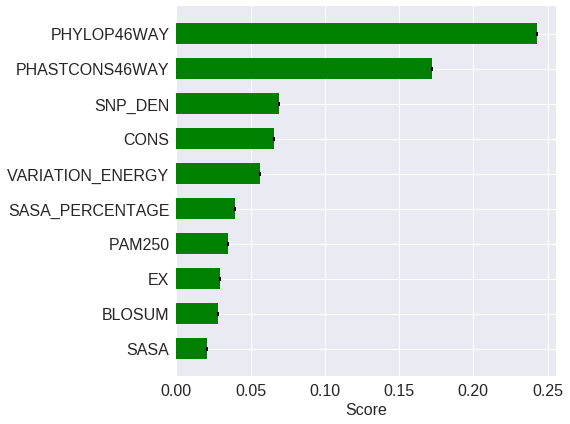

In [16]:
# cols = (cont_vars + cat_vars)
# ranking_size = 10
# forest = rf.steps[1][1]

# importances = [(cols[e], x) for e, x in enumerate(forest.feature_importances_)]
# importances.sort(key=operator.itemgetter(1), reverse=True)
# indices = np.argsort(forest.feature_importances_)[:ranking_size]
# importances = importances[:ranking_size][::-1]
# std = np.std([tree.feature_importances_ for tree in forest.estimators_],axis=0)
# plt.figure(figsize=(8,6))
# plt.barh(np.arange(len(importances)), [y for x, y in importances], 0.6, color="green", align="center", 
#          xerr=std[indices], ecolor="black", error_kw={"capthick":2, "capsize":2})
# plt.yticks(range(len(importances)), [x for x, y in importances], rotation='horizontal', fontsize=16)
# plt.xlabel("Score",fontsize=16)
# plt.xticks(fontsize=14)
# plt.tight_layout()

cols = (cont_vars + cat_vars)
ranking_size = 10
forest = rf.steps[1][1]

importances = [(cols[e], x) for e, x in enumerate(forest.feature_importances_)]
importances.sort(key=operator.itemgetter(1), reverse=True)
indices = np.argsort(forest.feature_importances_)[:ranking_size]
importances = importances[:ranking_size][::-1]
std = np.std([tree.feature_importances_ for tree in forest.estimators_],axis=0)
plt.figure(figsize=(8,6))
plt.barh(np.arange(len(importances)), [y for x, y in importances], 0.6, color="green", align="center", 
         xerr=std[indices], ecolor="black", error_kw={"capthick":2, "capsize":2})
plt.yticks(range(len(importances)), [x for x, y in importances], rotation='horizontal', fontsize=16)
plt.xlabel("Score",fontsize=16)
plt.xticks(fontsize=16)
plt.tight_layout()

# plt.savefig("/home/marlan/Desktop/importances_varq_integral.pdf", bbox_inches='tight', pad_inches=0.1)

In [22]:
from rfpimp import importances, plot_importances
imp = importances(rf, X_test, y_test) # permutation

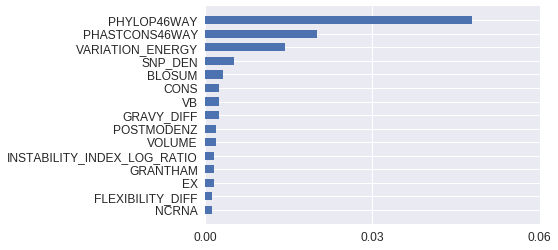

In [20]:
plot_importances(imp[:15])

In [17]:
fpr, tpr, _ = roc_curve(y_test, rf.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

In [18]:
roc_curve = pd.concat([pd.Series(fpr,name="fpr"), pd.Series(tpr, name="tpr")], axis=1)
roc_curve.to_csv("../results/varq_integral/auc_rf.csv", index=False)

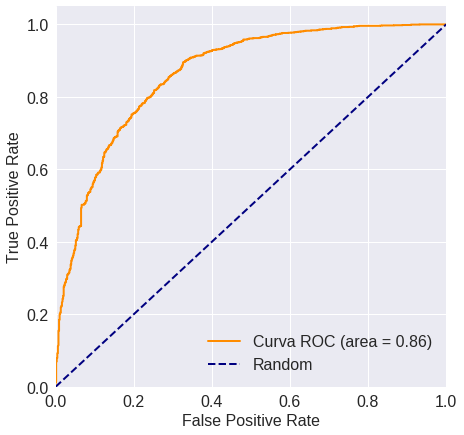

In [48]:
figsize(7,7)

lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='Curva ROC (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
# plt.title('AUC Curve')
plt.legend(loc="lower right", prop={'size': 16})

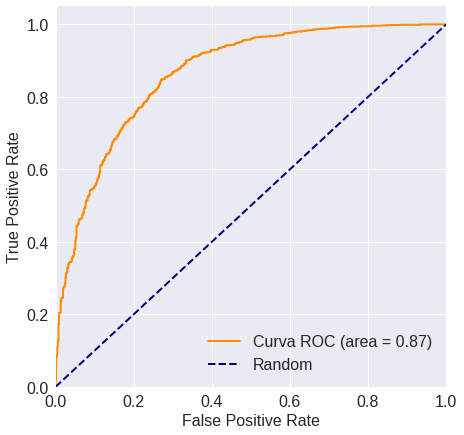

In [21]:
fpr, tpr, _ = roc_curve(y_test, rf.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

figsize(7,7)

lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='Curva ROC (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
# plt.title('AUC Curve')
plt.legend(loc="lower right", prop={'size': 16})

plt.savefig("/home/marlan/Desktop/auc_varq_integral.pdf", bbox_inches='tight', pad_inches=0.1)

In [49]:
print(classification_report(le.inverse_transform(y_test), le.inverse_transform(rf.predict(X_test))))

             precision    recall  f1-score   support

     Benign       0.81      0.53      0.64       674
 Pathogenic       0.84      0.95      0.89      1774

avg / total       0.83      0.83      0.82      2448



/home/marlan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/marlan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [66]:
features1 = ["GRANTHAM", "EX", "PAM250", "BLOSUM", "JM", "VB"] 
features2 = ["HYDROPHOBICITY", "POLARITY"]
features3 = ["CHARGE", "ISOELECTRIC_POINT_LOG_RATIO"]
features4 = ['PHYLOP46WAY', 'PHASTCONS46WAY']
features5 = ['SASA', 'SASA_PERCENTAGE']

features = X.drop(features1+features2+features3+features4+features5, axis=1).columns.tolist() + [features1] + [features2] + [features3] + [features4] + [features5]

In [67]:
import rfpimp
I = rfpimp.importances(rf, X_test, y_test, n_samples=-1, features=features)

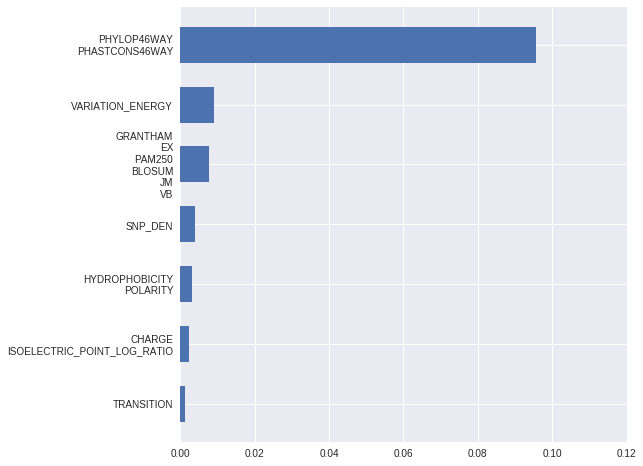

In [68]:
rfpimp.plot_importances(I.iloc[:7], label_fontsize=10, figsize=(8,8), tickstep=1, save="/home/marlan/Desktop/integral_varq_importance_cluster.pdf")